# Import Required Libraries
Import the necessary libraries, including the Eikon API.

In [2]:
# Import the necessary libraries, including the Eikon API
import eikon as ek
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage

# Set the Eikon API key
ek.set_app_key('cf2eaf5e3b3c42adba08b3c5c2002b6ced1e77d7')

# Define the ISINs for the funds we want to retrieve data for
isins = [
    'LP68644630', 'LP68422844', '/WLD.PA', 'LP68569647', 'LP60060386', 'LP60060398', 'LP60060399', 
    'LP68335443', 'LP68335464', 'LP68644626', 'LP68644639', 'LP68644656', 'LP68644670', 'LP68759031', 
]

In [3]:
# Calculate the start and end dates for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Retrieve tr.fundnav and tr.fundnav.date fields for all the ISINs for the last year
fields = ['tr.fundnav', 'tr.fundnav.date']
df_hist, err = ek.get_data(isins, fields, {'SDate': start_date.strftime('%Y-%m-%d'), 'EDate': end_date.strftime('%Y-%m-%d'), 'Frq': 'D'})

# Convert the 'Date' column to datetime format
df_hist['Date'] = pd.to_datetime(df_hist['Date']).dt.date

# Pivot the dataframe
df_wide = df_hist.pivot(index='Date', columns='Instrument', values='NAV')

# Calculate the logarithmic returns
logret = np.log(df_wide / df_wide.shift(1))

# Retrieve the tr.fundname for each ISIN
fund_names_data, err = ek.get_data(isins, ['tr.fundname'])
# display(fund_names_data)

# Check for errors
if err:
    print(f"Error: {err}")
else:
    # Create a dictionary with ISIN as the key and fund name as the value
    fund_names = dict(zip(fund_names_data['Instrument'], fund_names_data['Fund Name']))
    print("Fund names retrieved successfully:")
    print(fund_names)

# Calculate the correlation matrix of the logarithmic returns
correlation_matrix = logret.corr().rename(index=fund_names, columns=fund_names)

# Calculate the cumulative sum of logret
cumret = logret.cumsum()

Fund names retrieved successfully:
{'LP68644630': 'Allianz Cyber Security AT (EUR)', 'LP68422844': 'Allianz Global Artificial Intelligence AT (EUR)', '/WLD.PA': 'Amundi MSCI World II UCITS ETF Dist', 'LP68569647': 'BGF Circular Economy E2 EUR', 'LP60060386': 'BGF Sustainable Energy Fund E2 EUR', 'LP60060398': 'BGF World Gold E2 EUR', 'LP60060399': 'BGF World Healthscience E2 EUR', 'LP68335443': 'BSF Global Event Driven E2 EUR', 'LP68335464': 'BSF Global Event Driven E2 EUR Hgd', 'LP68644626': 'DB ESG Balanced SAA (EUR) LC', 'LP68644639': 'DB ESG Balanced SAA (EUR) Plus LC', 'LP68644656': 'DB ESG Conservative SAA (EUR) LC', 'LP68644670': 'DB ESG Conservative SAA (EUR) Plus LC', 'LP68759031': 'DB ESG Fixed Income LC'}


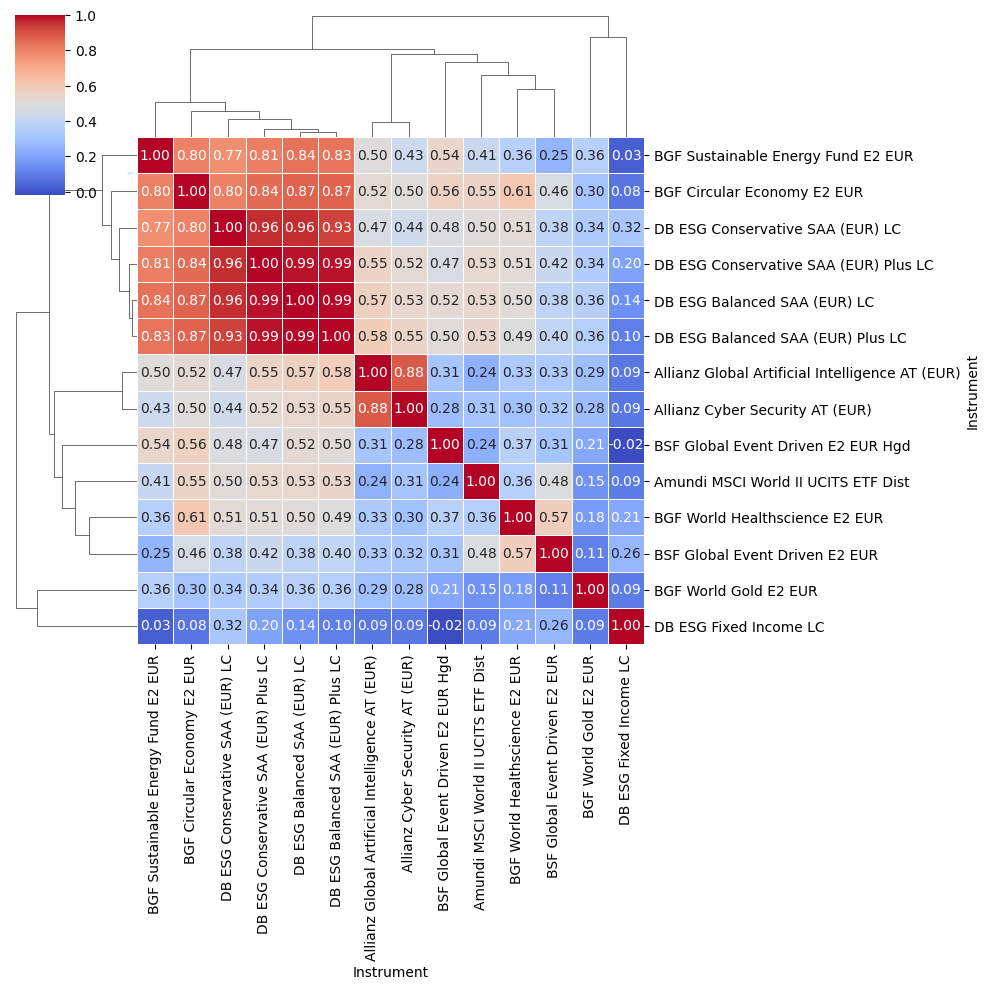

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate and plot the clustermap
sns.clustermap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

# Show the plot
plt.show()

In [5]:
# # Generate the Linkage Matrix
# # Convert the correlation matrix to a condensed distance matrix
distance_matrix = 1 - correlation_matrix

# # Generate the linkage matrix using the 'ward' method
linkage_matrix = linkage(distance_matrix, method='average')

# Create a dendrogram plot using Plotly with orientation set to 'right'
fig_dendro_right = ff.create_dendrogram(
    correlation_matrix.values,
    labels=correlation_matrix.index.tolist(),
    linkagefun=lambda x: linkage_matrix,
    orientation='right'
)

# Update the layout for better visualization and reverse the y-axis
fig_dendro_right.update_layout(
    width=800,
    height=500,
    title='Dendrogram of Correlation Matrix (Facing Right)',
    yaxis=dict(autorange='reversed')  # Reverse the y-axis
)

# Show the plot
fig_dendro_right.show()

# Retrieve the labels and values of the y-axis
y_axis_labels = fig_dendro_right['layout']['yaxis']['ticktext']
y_axis_values = fig_dendro_right['layout']['yaxis']['tickvals']

# Retrieve the color of each tick where x = 0
tick_colors = [trace['marker']['color'] for trace in fig_dendro_right['data'] if 'marker' in trace and 'color' in trace['marker'] and all(trace['x'] == 0)]

# Ensure tick_colors length matches y_axis_labels length
if len(tick_colors) < len(y_axis_labels):
    tick_colors.extend(['rgb(0,0,0)'] * (len(y_axis_labels) - len(tick_colors)))

# Display the labels and values
print("Y-axis labels:", y_axis_labels)
print("Y-axis values:", y_axis_values)
print("Y-axis colors:", tick_colors)

# Combine ticktext and tickvals to a dictionary
labels_to_values = dict(zip(y_axis_labels, y_axis_values))
values_to_labels = dict(zip(y_axis_values, y_axis_labels))

C:\Users\thoma\AppData\Local\Temp\ipykernel_8832\3277215216.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


Y-axis labels: ['BGF Sustainable Energy Fund E2 EUR' 'BGF Circular Economy E2 EUR'
 'DB ESG Conservative SAA (EUR) LC'
 'DB ESG Conservative SAA (EUR) Plus LC' 'DB ESG Balanced SAA (EUR) LC'
 'DB ESG Balanced SAA (EUR) Plus LC'
 'Allianz Global Artificial Intelligence AT (EUR)'
 'Allianz Cyber Security AT (EUR)' 'BSF Global Event Driven E2 EUR Hgd'
 'Amundi MSCI World II UCITS ETF Dist' 'BGF World Healthscience E2 EUR'
 'BSF Global Event Driven E2 EUR' 'BGF World Gold E2 EUR'
 'DB ESG Fixed Income LC']
Y-axis values: (5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, 105.0, 115.0, 125.0, 135.0)
Y-axis colors: ['rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)', 'rgb(0,0,0)']


In [6]:
linkage_matrix

array([[ 8.        , 10.        ,  0.06379458,  2.        ],
       [12.        , 14.        ,  0.10968486,  3.        ],
       [ 6.        ,  9.        ,  0.21076902,  2.        ],
       [11.        , 15.        ,  0.25849141,  4.        ],
       [ 7.        , 17.        ,  0.37941901,  5.        ],
       [ 1.        , 18.        ,  0.4961315 ,  6.        ],
       [ 3.        ,  4.        ,  0.68679293,  2.        ],
       [ 0.        , 20.        ,  0.89569566,  3.        ],
       [ 5.        , 21.        ,  1.07709141,  4.        ],
       [16.        , 22.        ,  1.20043264,  6.        ],
       [19.        , 23.        ,  1.26446213, 12.        ],
       [ 2.        , 13.        ,  1.44819033,  2.        ],
       [24.        , 25.        ,  1.74526976, 14.        ]])

In [7]:
# Extract x, y, marker color, and y-axis label information from fig_dendro_right['data']
data = []
for trace in fig_dendro_right['data']:
    if 'marker' in trace and 'color' in trace['marker']:
        for x, y in zip(trace['x'], trace['y']):
            label = values_to_labels.get(y, None)
            data.append({'x': x, 'y': y, 'color': trace['marker']['color'], 'label': label})

# Create a DataFrame from the extracted data
df_combinations = pd.DataFrame(data)

# Filter the DataFrame where x equals 0
df_combinations_filtered = df_combinations[df_combinations['x'] == 0]

# Display the filtered DataFrame
tickval_color_dict = df_combinations_filtered.set_index('y')['color'].to_dict()

tickval_color_dict

{45.0: 'rgb(61,153,112)',
 55.0: 'rgb(61,153,112)',
 35.0: 'rgb(61,153,112)',
 25.0: 'rgb(61,153,112)',
 15.0: 'rgb(61,153,112)',
 5.0: 'rgb(61,153,112)',
 65.0: 'rgb(255,65,54)',
 75.0: 'rgb(255,65,54)',
 105.0: 'rgb(255,65,54)',
 115.0: 'rgb(255,65,54)',
 95.0: 'rgb(255,65,54)',
 85.0: 'rgb(255,65,54)',
 125.0: 'rgb(0,116,217)',
 135.0: 'rgb(0,116,217)'}

In [8]:
# Calculate the cumulative sum of logret values for each ISIN
cumulative_logret = logret.rename(columns=fund_names).sum()
cumulative_logret = cumulative_logret.loc[y_axis_labels[::-1]]
cumulative_logret = cumulative_logret.rename(index=labels_to_values)

# Create a horizontal bar chart with custom marker colors
fig_cumulative_logret = px.bar(
    cumulative_logret,
    x=cumulative_logret.values,
    y=cumulative_logret.index,
    orientation='h',
    labels={'x': 'Cumulative Log Returns', 'y': 'ISIN'},
    title='Cumulative Sum of Log Returns for Each ISIN'
)

# Update the marker colors based on tickval_color_dict
for bar in fig_cumulative_logret.data:
    bar.marker.color = [tickval_color_dict[val] for val in bar.y]

# Show the plot
fig_cumulative_logret.show()

In [7]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.33, 1], 
    horizontal_spacing=0.01,
    shared_yaxes=True)

# Add the dendrogram (facing right) to the first column
for trace in fig_dendro_right['data']:
    fig.add_trace(trace, row=1, col=1)

# Update the y-axis labels to match the correlation matrix index
fig.update_yaxes(
    ticktext=correlation_matrix.index.tolist(),
    tickvals=list(map(labels_to_values.get, correlation_matrix.index.tolist())),
    autorange='reversed', 
    row=1, col=1
)

# Rescale the x-axis such that the new lowest value is 1.25 times the current lowest value
fig.update_xaxes(
    range=[min(trace['x'])*1.1, 0],
    showticklabels=False,
    row=1, col=1
)


fig.update_xaxes(
    showticklabels=False,
    row=1, col=2
)
# Add the cumulative log returns bar chart to the second column and update data labels and colors
for i, trace in enumerate(fig_cumulative_logret['data']):
    trace['text'] = [f'{x:.1%}' for x in trace['x']]
    trace['textposition'] = 'outside'
    fig.add_trace(trace, row=1, col=2)

# Update the layout for better visualization
fig.update_layout(
    height=600, width=1200, 
    title_text="Dendrogram and Cumulative Log Returns", 
    showlegend=False
)

# Show the plot
fig.show()

In [8]:
# Create a dendrogram plot using Plotly with orientation set to 'bottom'
fig_dendro_down = ff.create_dendrogram(
    correlation_matrix.values,
    labels=correlation_matrix.index.tolist(),
    linkagefun=lambda x: linkage_matrix,
    orientation='bottom'
)

# Update the layout for better visualization
fig_dendro_down.update_layout(width=800, height=500, title='Dendrogram of Correlation Matrix (Facing Down)')

# Show the plot
fig_dendro_down.show()

# Retrieve the labels of the x-axis
x_axis_labels = fig_dendro_down['layout']['xaxis']['ticktext']

# Display the labels
print("X-axis labels:", x_axis_labels)
# Retrieve the x-axis labels and corresponding x-axis values
x_axis_labels_values = list(zip(fig_dendro_down['layout']['xaxis']['ticktext'], fig_dendro_down['layout']['xaxis']['tickvals']))

# Display the labels and values
print("X-axis labels and values:", x_axis_labels_values)

# Retrieve the color of each tick
tick_colors_down = [trace['marker']['color'] for trace in fig_dendro_down['data'] if 'marker' in trace and 'color' in trace['marker']]

# Ensure tick_colors_down length matches x_axis_labels length
if len(tick_colors_down) < len(x_axis_labels):
    tick_colors_down.extend(['rgb(0,0,0)'] * (len(x_axis_labels) - len(tick_colors_down)))

# Display the tick colors
print("Tick colors:", tick_colors_down)

X-axis labels: ['BGF Sustainable Energy Fund E2 EUR' 'BGF Circular Economy E2 EUR'
 'DB ESG Conservative SAA (EUR) LC'
 'DB ESG Conservative SAA (EUR) Plus LC' 'DB ESG Balanced SAA (EUR) LC'
 'DB ESG Balanced SAA (EUR) Plus LC'
 'Allianz Global Artificial Intelligence AT (EUR)'
 'Allianz Cyber Security AT (EUR)' 'BSF Global Event Driven E2 EUR Hgd'
 'Amundi MSCI World II UCITS ETF Dist' 'BGF World Healthscience E2 EUR'
 'BSF Global Event Driven E2 EUR' 'BGF World Gold E2 EUR'
 'DB ESG Fixed Income LC']
X-axis labels and values: [('BGF Sustainable Energy Fund E2 EUR', 5.0), ('BGF Circular Economy E2 EUR', 15.0), ('DB ESG Conservative SAA (EUR) LC', 25.0), ('DB ESG Conservative SAA (EUR) Plus LC', 35.0), ('DB ESG Balanced SAA (EUR) LC', 45.0), ('DB ESG Balanced SAA (EUR) Plus LC', 55.0), ('Allianz Global Artificial Intelligence AT (EUR)', 65.0), ('Allianz Cyber Security AT (EUR)', 75.0), ('BSF Global Event Driven E2 EUR Hgd', 85.0), ('Amundi MSCI World II UCITS ETF Dist', 95.0), ('BGF Wo

In [9]:
import plotly.express as px

# Create a heatmap of the correlation matrix
fig_heatmap = px.imshow(correlation_matrix, 
                        labels=dict(x="Funds", y="Funds", color="Correlation"),
                        x=correlation_matrix.columns,
                        y=correlation_matrix.index,
                        color_continuous_scale='RdBu_r')

# Update layout for better visualization
fig_heatmap.update_layout(title='Heatmap of Correlation Matrix',
                          width=800,
                          height=800,
                          xaxis_title='Funds',
                          yaxis_title='Funds')

# Show the plot
fig_heatmap.show()

In [10]:

# Sort the correlation matrix columns using x_axis_labels
sorted_correlation_matrix = correlation_matrix.loc[x_axis_labels, y_axis_labels]

# Display the sorted correlation matrix
display(sorted_correlation_matrix)

import plotly.express as px

# Create a heatmap of the sorted correlation matrix
fig_sorted_heatmap = px.imshow(sorted_correlation_matrix, 
                               labels=dict(x="Funds", y="Funds", color="Correlation"),
                               x=sorted_correlation_matrix.columns,
                               y=sorted_correlation_matrix.index,
                               color_continuous_scale='RdBu_r')

# Update layout for better visualization
fig_sorted_heatmap.update_layout(title='Heatmap of Sorted Correlation Matrix',
                                 width=800,
                                 height=800,
                                 xaxis_title='Funds',
                                 yaxis_title='Funds')

# Show the plot
fig_sorted_heatmap.show()

Instrument,BGF Sustainable Energy Fund E2 EUR,BGF Circular Economy E2 EUR,DB ESG Conservative SAA (EUR) LC,DB ESG Conservative SAA (EUR) Plus LC,DB ESG Balanced SAA (EUR) LC,DB ESG Balanced SAA (EUR) Plus LC,Allianz Global Artificial Intelligence AT (EUR),Allianz Cyber Security AT (EUR),BSF Global Event Driven E2 EUR Hgd,Amundi MSCI World II UCITS ETF Dist,BGF World Healthscience E2 EUR,BSF Global Event Driven E2 EUR,BGF World Gold E2 EUR,DB ESG Fixed Income LC
Instrument,,,,,,,,,,,,,,
BGF Sustainable Energy Fund E2 EUR,1.000000,0.799152,0.771987,0.806903,0.836607,0.832415,0.501693,0.440588,0.535474,0.416084,0.361583,0.253851,0.356950,0.034082
BGF Circular Economy E2 EUR,0.799152,1.000000,0.797241,0.840691,0.864165,0.862562,0.521280,0.501135,0.558329,0.548334,0.609075,0.461636,0.302274,0.074431
DB ESG Conservative SAA (EUR) LC,0.771987,0.797241,1.000000,0.958212,0.957088,0.926848,0.474706,0.442242,0.482665,0.507830,0.511594,0.383585,0.334072,0.325831
DB ESG Conservative SAA (EUR) Plus LC,0.806903,0.840691,0.958212,1.000000,0.986156,0.986424,0.553841,0.519690,0.472707,0.531168,0.507536,0.421083,0.342562,0.200767
DB ESG Balanced SAA (EUR) LC,0.836607,0.864165,0.957088,0.986156,1.000000,0.992973,0.571301,0.536451,0.519635,0.536933,0.502012,0.383171,0.356760,0.149586
DB ESG Balanced SAA (EUR) Plus LC,0.832415,0.862562,0.926848,0.986424,0.992973,1.000000,0.586073,0.553499,0.504462,0.538243,0.491738,0.399592,0.352252,0.106429
Allianz Global Artificial Intelligence AT (EUR),0.501693,0.521280,0.474706,0.553841,0.571301,0.586073,1.000000,0.883900,0.314828,0.248298,0.333780,0.326495,0.294418,0.091173
Allianz Cyber Security AT (EUR),0.440588,0.501135,0.442242,0.519690,0.536451,0.553499,0.883900,1.000000,0.280856,0.312484,0.295450,0.320367,0.289646,0.088351
BSF Global Event Driven E2 EUR Hgd,0.535474,0.558329,0.482665,0.472707,0.519635,0.504462,0.314828,0.280856,1.000000,0.242111,0.364004,0.311075,0.209562,-0.012796


In [11]:

from plotly.subplots import make_subplots

# Create a subplot with 2 rows and 2 columns
fig = make_subplots(
    rows=2, cols=2,
    vertical_spacing=0.01, horizontal_spacing=0.01,
    row_heights=[0.3, 0.7],  # Adjust the heights of the rows
    column_widths=[0.3, 0.7],  # Adjust the widths of the columns
    specs=[[None, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "heatmap"}]]
)

# Add the dendrogram (facing down) to the first row, second column
for trace in fig_dendro_down['data']:
    fig.add_trace(trace, row=1, col=2)

# Add the dendrogram (facing right) to the second row, first column
for trace in fig_dendro_right['data']:
    fig.add_trace(trace, row=2, col=1)

# Add the sorted heatmap to the second row, second column
for trace in fig_sorted_heatmap['data']:
    fig.add_trace(trace, row=2, col=2)

# Update the layout for better visualization
fig.update_layout(height=1000, width=1000, title_text="Combined Plots",
                  showlegend=False, coloraxis_showscale=False)
        


# Show the plot
fig.show()